In [1]:
import tensorflow as tensorflow
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(455)
np.random.seed(455)



In [2]:
#set index to date, parse date as date object, drop adjusted close
dataset = pd.read_csv(
    "TSLA.csv", index_col="Date", parse_dates=["Date"]).drop(["Adj Close"],axis= 1)
print(dataset.head())



             Open   High    Low  Close    Volume
Date                                            
2010-06-29  3.800  5.000  3.508  4.778  93831500
2010-06-30  5.158  6.084  4.660  4.766  85935500
2010-07-01  5.000  5.184  4.054  4.392  41094000
2010-07-02  4.600  4.620  3.742  3.840  25699000
2010-07-06  4.000  4.000  3.166  3.222  34334500


In [3]:
#statistics summary
print(dataset.describe())


              Open         High          Low        Close        Volume
count  2956.000000  2956.000000  2956.000000  2956.000000  2.956000e+03
mean    138.691296   141.771603   135.425953   138.762183  3.131449e+07
std     250.044839   255.863239   243.774157   250.123115  2.798383e+07
min       3.228000     3.326000     2.996000     3.160000  5.925000e+05
25%      19.627000    20.402000    19.127500    19.615000  1.310288e+07
50%      46.656999    47.487001    45.820002    46.545000  2.488680e+07
75%      68.057001    69.357500    66.911501    68.103998  3.973875e+07
max    1234.410034  1243.489990  1217.000000  1229.910034  3.046940e+08


In [4]:
#
dataset.isna().sum()


Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

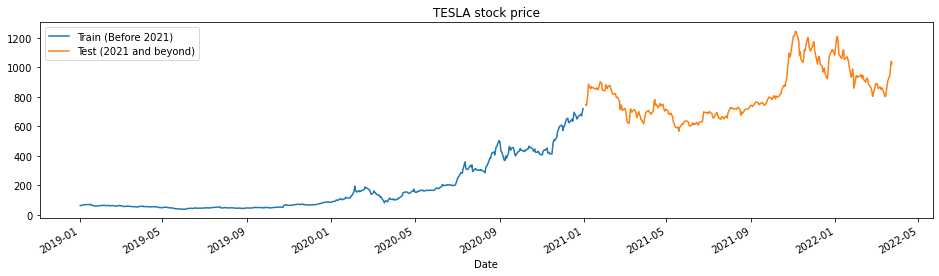

In [27]:
tstart = 2019 #test start
tend = 2020  #test end 

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("TESLA stock price")
    plt.show()

train_test_plot(dataset,tstart,tend)


In [6]:
#split data into 2 subsets: Train and Test
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"].values # tfrom tstart to tend
    test = dataset.loc[f"{tend+1}":, "High"].values #from tend to end of dataset
    return train, test
training_set, test_set = train_test_split(dataset, tstart, tend)


In [7]:
sc = MinMaxScaler(feature_range=(0, 1)) #sklearn.processing module scaler to standardize
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)


In [8]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 30
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)


In [9]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)


In [10]:
# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()
Model: "sequential"

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 125)               63500     
                                                                 
 dense (Dense)               (None, 1)                 126       
                                                                 
Total params: 63,626
Trainable params: 63,626
Non-trainable params: 0
_________________________________________________________________


In [11]:
model_lstm.fit(X_train, y_train, epochs= 100, batch_size=32)



Epoch 1/100
15/15 [==============================] - 2s 16ms/step - loss: 0.0102
Epoch 2/100
15/15 [==============================] - 0s 18ms/step - loss: 0.0024
Epoch 3/100
15/15 [==============================] - 0s 18ms/step - loss: 0.0029
Epoch 4/100
15/15 [==============================] - 0s 20ms/step - loss: 0.0015
Epoch 5/100
15/15 [==============================] - 0s 21ms/step - loss: 0.0020
Epoch 6/100
15/15 [==============================] - 0s 19ms/step - loss: 0.0014
Epoch 7/100
15/15 [==============================] - 0s 21ms/step - loss: 0.0013
Epoch 8/100
15/15 [==============================] - 0s 31ms/step - loss: 0.0016
Epoch 9/100
15/15 [==============================] - 0s 24ms/step - loss: 0.0013
Epoch 10/100
15/15 [==============================] - 0s 21ms/step - loss: 0.0012
Epoch 11/100
15/15 [==============================] - 0s 18ms/step - loss: 0.0010
Epoch 12/100
15/15 [==============================] - 0s 26ms/step - loss: 0.0012
Epoch 13/100
15/15 [=====

Epoch 97/100
15/15 [==============================] - 0s 15ms/step - loss: 4.7543e-04
Epoch 98/100
15/15 [==============================] - 0s 15ms/step - loss: 4.6453e-04
Epoch 99/100
15/15 [==============================] - 0s 15ms/step - loss: 4.8895e-04
Epoch 100/100
15/15 [==============================] - 0s 15ms/step - loss: 4.6481e-04


In [12]:
dataset_total = dataset.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


10/10 [==============================] - 0s 8ms/step


In [28]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Tesla Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("Tesla Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))


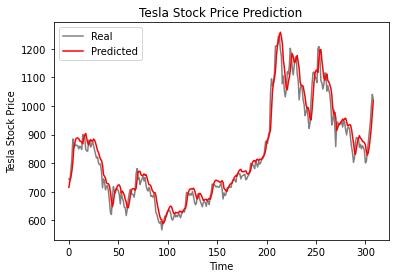

In [29]:
plot_predictions(test_set,predicted_stock_price)


In [24]:
return_rmse(test_set,predicted_stock_price)


The root mean squared error is 36.57.
